In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
# альтернативно можно использовать StratifiedKFold т.к. задача классификации
import seaborn as sns # чтобы подкрасить таблички

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)


In [ ]:
from google.colab import files # чтобы загружать файлы в облако через проводник
uploaded = files.upload() #просто запускаем и выбираем файл  API токена в проводнике

#↓ строка которая активирует наш API токен
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:

#↓ добавился восклицательный знак, потому что это колаб
!kaggle competitions download -c urfuaieng2022reg2

urfuaieng2022reg2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip urfuaieng2022reg2.zip

Archive:  urfuaieng2022reg2.zip
replace Submission_reg.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Submission_reg.csv      
  inflating: Test_Who.csv            
  inflating: Train_Target_reg.csv    
  inflating: Train_Who.csv           
  inflating: assessments.csv         
  inflating: courses.csv             
  inflating: studentAssessment.csv   
  inflating: studentInfo.csv         
  inflating: studentRegistration.csv  
  inflating: studentVle.csv          
  inflating: vle.csv                 


# Загружаем данные в Pandas

In [ ]:
ass = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
results = pd.read_csv('studentAssessment.csv')
info = pd.read_csv('studentInfo.csv')
reg = pd.read_csv('studentRegistration.csv')
vle = pd.read_csv('studentVle.csv')
materials = pd.read_csv('vle.csv')
Train_Who = pd.read_csv('Train_Who.csv')
Test_Who = pd.read_csv('Test_Who.csv')
Target = pd.read_csv('Train_Target_reg.csv', index_col = 'ID')
submission = pd.read_csv('Submission_reg.csv', index_col = 'ID')


Посмотрим на таблицы

In [ ]:
display('assessments', ass.shape, ass.head(2))
display('courses', courses.shape, courses.head(2))
display('results', results.shape, results.head(2))
display('info', info.shape, info.head(2))
display('Registration', reg.shape, reg.head(2))
display('studentVle', vle.shape, vle.head(2))
display('materials', materials.shape, materials.head(2))

'assessments'

(206, 6)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0


'courses'

(22, 3)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269


'results'

(173912, 4)

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0


'info'

(32593, 11)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N


'Registration'

(32593, 4)

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0


'studentVle'

(10655280, 6)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1


'materials'

(6364, 6)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN


In [ ]:
display('Train_Who', Train_Who.shape, Train_Who.head(2))
display('Test_Who', Test_Who.shape, Test_Who.head(2))
display('Target', Target.shape, Target.head(2))

'Train_Who'

(26074, 4)

,ID,id_student,code_module,code_presentation
0,0,464685,DDD,2014B
1,1,606593,DDD,2013J


'Test_Who'

(6519, 4)

,ID,id_student,code_module,code_presentation
0,26074,2588655,DDD,2014J
1,26075,543628,CCC,2014B


'Target'

(26074, 1)

,weighted_score
ID,
0,64.9125
1,14.8625


## Некоторые полезные функции для анализа таблиц между собой


In [ ]:
def compareCols(df1: pd.DataFrame, df2: pd.DataFrame):
    '''
    Проверяет есть ли совпадения по столбцам в датафрейймах
    '''

    # Показать общие столбцы между фреймами данных
    # (a) Составьте списки столбцов для каждого фрейма данных
    df1Columns = df1.columns.values.tolist()
    df2Columns = df2.columns.values.tolist()

    # (b) Найдите одинаковые имена столбцов
    diffDict = set(df1Columns) & set(df2Columns)

    print('Общие колонки : ', diffDict, '\n')

    # (c) Составьте список из словаря
    diffList = list(diffDict)
    # (d) Убедитесь, что если значения в
    # каждый общий столбец совпадает в
    # двух фреймах данных
    for col in diffList:
        x = df1[col].isin(df2[col]).value_counts()
        print('Проверяем, присутствуют ли значения в обоих фреймах данных:')
        print(x, '\n')

In [ ]:
def findDiffValues(df1: pd.DataFrame, df2: pd.DataFrame, col: str):
    '''
    Найти все значения df1.col, отсутствующие в df2.col
    '''
    # Вытащите все уникальные значения col
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    # Сравните два списка
    # (a) Найдите, какие значения отличаются
    diff = set(df1_IDs).difference(set(df2_IDs))
    # (b) осчитайте, сколько разных
    numberDiff = len(diff)

    print("Значения из df1 не в df2: " + str(diff))
    print("Количество пропущенных значений: " + str(numberDiff))

    return diff

In [ ]:
def printDiffValues(df1: pd.DataFrame, df2: pd.DataFrame, col: str):
    '''
    Показать все значения df1.col, отсутствующие в df2.col
    '''
    # Вытащить все уникальные значения col
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    # Сравните два списка
    # (a) Найдите, какие значения отличаются
    diff = set(df1_IDs).difference(set(df2_IDs))

    # Показать информацию обо всех значениях df1.col, отсутствующих в df2.col
    # (a) Составьте список недостающих значений
    missingList = list(diff)
    # (b) Найдите эти идентификаторы в df2
    missingDf = df1[df1[col].isin(missingList)]

    return missingDf

## Assessments info (информация об оценках)

In [ ]:
ass.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
ass['id_assessment'] = ass['id_assessment'].astype(object)
ass.head(2)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0


In [ ]:
print(ass.isna().sum())
ass[ass['date'].isna()]

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64


,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Кажется, что в некоторых модулях-презентациях, когда тип оценки указан как "Экзамен", в столбце "дата" есть пустые значения. Для этого типа оценки должна быть оценка, и ей назначен вес, но не указано время подготовки.

Кроме того, мы можем заметить, что в случаях, когда дата указана, она совпадает с максимальной датой для данного модуля-презентации, и это имеет логическое объяснение. В конечном счете, подготовка к экзамену начинается с самого первого дня курса.

## Assessments results (результаты оценки)


In [ ]:
results.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id_assessment   173912 non-null  int64
 1   id_student      173912 non-null  int64
 2   date_submitted  173912 non-null  int64
 3   is_banked       173912 non-null  int64
dtypes: int64(4)
memory usage: 5.3 MB


In [ ]:
results['id_assessment'] = results['id_assessment'].astype(object)
results['id_student'] = results['id_student'].astype(object)

In [ ]:
results.head(2)

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0


In [ ]:
agged_stud_ass = results.groupby('id_student').agg(mean_date_submitted=('date_submitted', 'mean'))
display(agged_stud_ass.shape)
agged_stud_ass.tail(2)

(23369, 1)

,mean_date_submitted
id_student,
2698577,106.2
2698588,106.8


### Сравнение наполнения датафреймов

In [ ]:
compareCols(ass, results)

Общие колонки :  {'id_assessment'} 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True     188
False     18
Name: id_assessment, dtype: int64 



18 `id_assessment`не хватает

уточним какие:

In [ ]:
findDiffValues(ass, results, 'id_assessment')

Значения из df1 не в df2: {30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911}
Количество пропущенных значений: 18


{1757,
 1763,
 14990,
 15002,
 15014,
 15025,
 30713,
 30718,
 30723,
 34872,
 34885,
 34898,
 34911,
 37424,
 37434,
 37444,
 40087,
 40088}

In [ ]:
printDiffValues(ass, results, 'id_assessment')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0
113,EEE,2013J,30713,Exam,235.0,100.0
118,EEE,2014B,30718,Exam,228.0,100.0


При анализе датафрейма 'results' можно обнаружить отсутствие значения 'id_assessment' для некоторых экзаменов. Давайте взглянем на строки в датасете, начиная с 'id_assessment' == 1757 и до неё, чтобы проверить эту информацию.

In [ ]:
display(ass[ass['id_assessment'] <= 1757])
display(results[results['id_assessment'] <= 1757])


,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
5,AAA,2013J,1757,Exam,NaN,100.0


,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0
2,1752,31604,17,0
3,1752,32885,26,0
4,1752,38053,19,0
...,...,...,...,...
1628,1756,572652,215,0
1629,1756,580389,215,0
1630,1756,588775,213,0
1631,1756,591774,215,0


In [ ]:
results[results['id_assessment'] <= 1757].groupby('id_student')['id_assessment'].unique()

id_student
11391      [1752, 1753, 1754, 1755, 1756]
28400      [1752, 1753, 1754, 1755, 1756]
31604      [1752, 1753, 1754, 1755, 1756]
32885      [1752, 1753, 1754, 1755, 1756]
38053      [1752, 1753, 1754, 1755, 1756]
                        ...              
2689958    [1752, 1753, 1754, 1755, 1756]
2691206    [1752, 1753, 1754, 1755, 1756]
2691244          [1753, 1754, 1755, 1756]
2694424    [1752, 1753, 1754, 1755, 1756]
2698257    [1752, 1753, 1754, 1755, 1756]
Name: id_assessment, Length: 365, dtype: object

Обратив внимание, становится ясно, что студенты в модуле 'AAA-2013J' оцениваются с использованием тех же самых презентаций. Поэтому, в датасете 'results', можно взять значение 'id_assessment' ниже и скопировать все соответствующие строки, изменяя значение на требуемое.

Скопируем датафрейм, чтобы не потерять

In [ ]:
results_cor = results.copy()
results_cor.shape

(173912, 4)

In [ ]:
exams_nan = sorted(list(findDiffValues(ass, results, 'id_assessment')))

Значения из df1 не в df2: {30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911}
Количество пропущенных значений: 18


In [ ]:
for i in exams_nan: # Проходим по списку недостающих значений
    prev = i-1
    changed = results_cor[results_cor['id_assessment']==prev] # Считываем все строки с предыдущим значением
    changed.loc[:,'id_assessment'].replace(prev, i, inplace=True) # Заменяем на текущее
    results_cor = pd.concat([results_cor, changed]) # Присоединяем к датафрейму

In [ ]:
results_cor

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0
2,1752,31604,17,0
3,1752,32885,26,0
4,1752,38053,19,0
...,...,...,...,...
173907,37444,527538,227,0
173908,37444,534672,229,0
173909,37444,546286,215,0
173910,37444,546724,230,0


In [ ]:
printDiffValues(ass, results_cor, 'id_assessment')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
63,CCC,2014B,40087,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Есть еще два значения, которые не удалось восстановить.

In [ ]:
ass[(ass['code_module'] == 'CCC') & (ass['code_presentation'] =='2014B')]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
54,CCC,2014B,24286,CMA,18.0,2.0
55,CCC,2014B,24287,CMA,67.0,7.0
56,CCC,2014B,24288,CMA,137.0,8.0
57,CCC,2014B,24289,CMA,207.0,8.0
58,CCC,2014B,24282,TMA,32.0,9.0
59,CCC,2014B,24283,TMA,102.0,22.0
60,CCC,2014B,24284,TMA,151.0,22.0
61,CCC,2014B,24285,TMA,200.0,22.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0


In [ ]:
ass[(ass['code_module'] == 'CCC') & (ass['code_presentation'] == '2014J')]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
64,CCC,2014J,24295,CMA,18.0,2.0
65,CCC,2014J,24296,CMA,67.0,7.0
66,CCC,2014J,24297,CMA,144.0,8.0
67,CCC,2014J,24298,CMA,214.0,8.0
68,CCC,2014J,24291,TMA,32.0,9.0
69,CCC,2014J,24292,TMA,109.0,22.0
70,CCC,2014J,24293,TMA,158.0,22.0
71,CCC,2014J,24294,TMA,207.0,22.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Строки с 'id_assessment' 40087 и 40088 вызывают подозрение, так как они соответствуют двум экзаменам в одном модуле, и числа кажутся произвольными. Пока оставим эти строки без изменений.

## Courses info (информация о курсах)

In [ ]:
courses.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [ ]:
courses.head(2)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269


## Student registration (регистрация студентов)

In [ ]:
# информация о данных в датафрейме
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


In [ ]:
reg['id_student'] = reg['id_student'].astype(object)
reg.head(2)

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0


## VLE resources

In [ ]:
# информация о данных в датафрейме
materials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [ ]:
materials['id_site'] = materials['id_site'].astype(object)
materials.head(2)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN


In [ ]:
materials['activity_type'].unique()

array(['resource', 'oucontent', 'url', 'homepage', 'subpage', 'glossary',
       'forumng', 'oucollaborate', 'dataplus', 'quiz', 'ouelluminate',
       'sharedsubpage', 'questionnaire', 'page', 'externalquiz', 'ouwiki',
       'dualpane', 'repeatactivity', 'folder', 'htmlactivity'],
      dtype=object)

## VLE Interactions

In [ ]:
# информация о данных в датафрейме
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [ ]:
vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)
vle.head(2)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1


## Student information

In [ ]:
 # информация о данных в датафрейме
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


In [ ]:
info['id_student'] = info['id_student'].astype(object)
info.head(2)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N


## Регистрация + Информация о курсах + Инфа о студентах

In [ ]:
print('Registration size:', reg.shape)
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='outer')
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')
print('Registration + Courses size:', reg.shape)
regCoursesInfo.sample(4)

Registration size: (32593, 4)
Registration + Courses size: (32593, 4)


,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
32400,GGG,2014J,684169,-29.0,269,F,South West Region,HE Qualification,30-40%,35-55,0,30,N
22179,EEE,2014J,696464,-21.0,269,M,South East Region,Lower Than A Level,20-30%,0-35,0,30,N
9441,CCC,2014B,563819,-177.0,241,M,South East Region,A Level or Equivalent,50-60%,0-35,0,90,Y
30852,GGG,2013J,606052,-24.0,261,F,North Western Region,Lower Than A Level,30-40%,35-55,0,30,Y


In [ ]:
dataset= (
    pd.merge(
        regCoursesInfo,
        agged_stud_ass,
        how='left',
        on=['id_student']
    )
)
dataset.tail(2)

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted
32591,GGG,2014J,2679821,-49.0,269,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,65.500000
32592,GGG,2014J,2684003,-28.0,269,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,131.571429


### Results

Давайте посчитаем количество строк с результатами для каждого студента и запишем это число, указывающее, сколько презентаций студент в общей сложности сдал.

In [ ]:
res_count = results_cor.groupby('id_student')['id_assessment'].count().reset_index()
res_count = res_count.rename(columns={'id_assessment':'res_count'})
res_count.head(2)

,id_student,res_count
0,6516,6
1,8462,7


In [ ]:
dataset = pd.merge(dataset, res_count, on='id_student', how='left')
print(dataset.shape)
dataset.head(2)

(32593, 15)


,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,112.4,6.0
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,114.2,6.0


генерация признак-0

In [ ]:

vle.date.value_counts(normalize=True)[:5]

18    0.009677
2     0.009625
17    0.009445
16    0.009279
3     0.008705
Name: date, dtype: float64

In [ ]:
vle['Click_Timing'] = ['Before' if date < 0 else 'After' for date in vle['date']]

vle['Before_Clicks_1']= np.where(vle['Click_Timing'] =='Before',
                                                 vle['sum_click'], 18)


 # Create a new dataframe by Grouping the columns

student_vle_merge_vle_group = vle.groupby(['code_module', 'code_presentation', 'id_student']
                                          ,as_index=False)[  'Before_Clicks_1'].sum()


dataset=dataset.merge(student_vle_merge_vle_group, on = ['id_student','code_module'	,'code_presentation'], how='left')


In [ ]:
group_date=vle.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["date"].sum()
dataset=dataset.merge(group_date, on =['code_module', 'code_presentation', 'id_student'], how = 'inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29228 entries, 0 to 29227
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 29228 non-null  object 
 1   code_presentation           29228 non-null  object 
 2   id_student                  29228 non-null  object 
 3   date_registration           29221 non-null  float64
 4   module_presentation_length  29228 non-null  int64  
 5   gender                      29228 non-null  object 
 6   region                      29228 non-null  object 
 7   highest_education           29228 non-null  object 
 8   imd_band                    28174 non-null  object 
 9   age_band                    29228 non-null  object 
 10  num_of_prev_attempts        29228 non-null  int64  
 11  studied_credits             29228 non-null  int64  
 12  disability                  29228 non-null  object 
 13  mean_date_submitted         263

In [ ]:
new_df=dataset.copy()

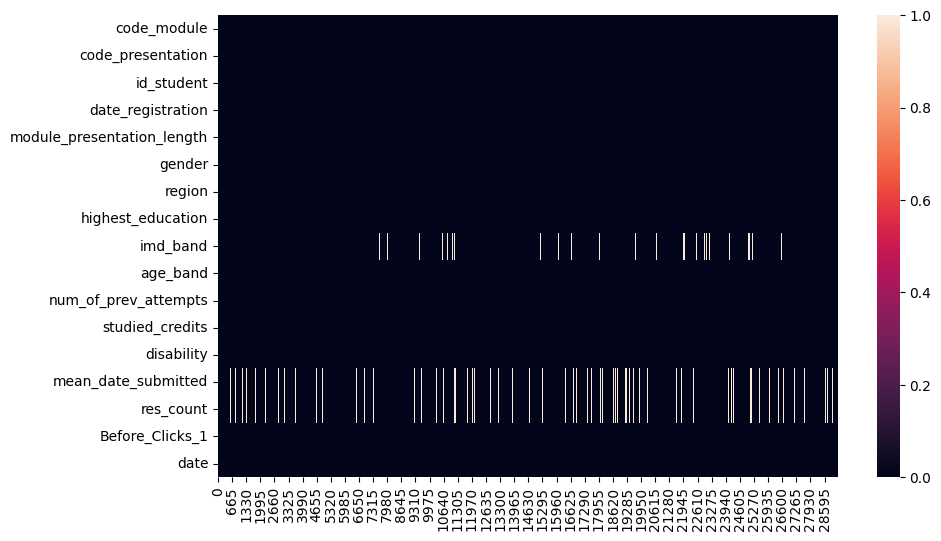

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(new_df.isna().transpose());

In [ ]:
df_rich = dataset.copy()
df_rich.sample(4)

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count,Before_Clicks_1,date
20404,FFF,2013B,520360,-177.0,240,F,South Region,HE Qualification,50-60%,35-55,0,120,N,13.00,1.0,5668.0,6448
12052,DDD,2013B,540920,-52.0,240,M,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,N,29.50,2.0,1198.0,1563
24027,FFF,2014B,612638,-141.0,241,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,60,N,47.50,6.0,7019.0,19147
26437,FFF,2014J,687351,-25.0,269,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,135.75,13.0,13005.0,85858


In [ ]:
df_rich.isna().sum()

code_module                      0
code_presentation                0
id_student                       0
date_registration                7
module_presentation_length       0
gender                           0
region                           0
highest_education                0
imd_band                      1054
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
mean_date_submitted           2897
res_count                     2897
Before_Clicks_1                  0
date                             0
dtype: int64

# Выделение тренировочной и тестовой выборки

In [ ]:
display(Train_Who.head(2))
display(Test_Who.head(2))

,ID,id_student,code_module,code_presentation
0,0,464685,DDD,2014B
1,1,606593,DDD,2013J


,ID,id_student,code_module,code_presentation
0,26074,2588655,DDD,2014J
1,26075,543628,CCC,2014B


Хорошо, мы выполним операцию объединения типа Left Join для основного датафрейма с содержимым 'Train_Who', чтобы не упустить никакую информацию оттуда.

In [ ]:
#                                               ↓ по каким колонкам будем объединять               ↓ как
Train = pd.merge(Train_Who, df_rich, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Train.index = Train.ID
# удаляем как столбец, ибо зачем
Train.drop(columns = ['ID'], inplace = True)
Train.head(2)

,id_student,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count,Before_Clicks_1,date
ID,,,,,,,,,,,,,,,,,
0,464685,DDD,2014B,-36.0,241.0,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1.0,70.0,N,123.285714,7.0,10461.0,65566.0
1,606593,DDD,2013J,-32.0,261.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,120.0,N,55.333333,3.0,5422.0,9671.0


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  26074 non-null  object 
 1   code_module                 26074 non-null  object 
 2   code_presentation           26074 non-null  object 
 3   date_registration           23360 non-null  float64
 4   module_presentation_length  23364 non-null  float64
 5   gender                      23364 non-null  object 
 6   region                      23364 non-null  object 
 7   highest_education           23364 non-null  object 
 8   imd_band                    22521 non-null  object 
 9   age_band                    23364 non-null  object 
 10  num_of_prev_attempts        23364 non-null  float64
 11  studied_credits             23364 non-null  float64
 12  disability                  23364 non-null  object 
 13  mean_date_submitted         210

In [ ]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Test = pd.merge(Test_Who, df_rich, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Test.index = Test.ID
# удаляем как столбец, ибо зачем
Test.drop(columns = ['ID'], inplace = True)
Test.head()

,id_student,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count,Before_Clicks_1,date
ID,,,,,,,,,,,,,,,,,
26074,2588655,DDD,2014J,-92.0,262.0,M,Scotland,Lower Than A Level,50-60%,0-35,2.0,60.0,N,85.777778,9.0,846.0,6553.0
26075,543628,CCC,2014B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26076,387276,BBB,2013B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26077,692219,CCC,2014J,-34.0,269.0,M,South Region,A Level or Equivalent,20-30%,0-35,0.0,90.0,N,21.000000,1.0,1553.0,776.0
26078,516212,BBB,2013J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 26074 to 32592
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  6519 non-null   object 
 1   code_module                 6519 non-null   object 
 2   code_presentation           6519 non-null   object 
 3   date_registration           5861 non-null   float64
 4   module_presentation_length  5864 non-null   float64
 5   gender                      5864 non-null   object 
 6   region                      5864 non-null   object 
 7   highest_education           5864 non-null   object 
 8   imd_band                    5653 non-null   object 
 9   age_band                    5864 non-null   object 
 10  num_of_prev_attempts        5864 non-null   float64
 11  studied_credits             5864 non-null   float64
 12  disability                  5864 non-null   object 
 13  mean_date_submitted         

# Целевая переменная

Для регрессии - это взешенная оценка отдельного **студента** за конкретную **презентацию** по конкретному **модулю**

In [ ]:
Target

,weighted_score
ID,
0,64.9125
1,14.8625
2,61.4300
3,39.5000
4,9.2500
...,...
26069,75.0000
26070,75.0000
26071,1.0000


# Предварительная обработка данных

## Дубликаты

Давайте выполним проверку на наличие дубликатов в нашем датафрейме.

In [ ]:
Train.duplicated().sum(), Test.duplicated().sum()

(0, 0)

Дубликатов не найдено.

Хорошо, проверим наличие пропущенных значений в нашем датафрейме.

In [ ]:
Train.isna().sum()

id_student                       0
code_module                      0
code_presentation                0
date_registration             2714
module_presentation_length    2710
gender                        2710
region                        2710
highest_education             2710
imd_band                      3553
age_band                      2710
num_of_prev_attempts          2710
studied_credits               2710
disability                    2710
mean_date_submitted           5051
res_count                     5051
Before_Clicks_1               2710
date                          2710
dtype: int64

In [ ]:
Test.isna().sum()

id_student                       0
code_module                      0
code_presentation                0
date_registration              658
module_presentation_length     655
gender                         655
region                         655
highest_education              655
imd_band                       866
age_band                       655
num_of_prev_attempts           655
studied_credits                655
disability                     655
mean_date_submitted           1211
res_count                     1211
Before_Clicks_1                655
date                           655
dtype: int64

В колонках имеются пропуски. Давайте проведем анализ данных и посмотрим, как эти пропуски будут влиять на наши результаты. После этого мы сможем принять решение о том, что делать с этими пропусками.

# EDA

Хорошо, давайте добавим целевую переменную к нашему датафрейму, чтобы проанализировать, как различные признаки влияют на успеваемость.

In [ ]:
df = pd.merge(Train, Target, on=['ID'], how='left')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  26074 non-null  object 
 1   code_module                 26074 non-null  object 
 2   code_presentation           26074 non-null  object 
 3   date_registration           23360 non-null  float64
 4   module_presentation_length  23364 non-null  float64
 5   gender                      23364 non-null  object 
 6   region                      23364 non-null  object 
 7   highest_education           23364 non-null  object 
 8   imd_band                    22521 non-null  object 
 9   age_band                    23364 non-null  object 
 10  num_of_prev_attempts        23364 non-null  float64
 11  studied_credits             23364 non-null  float64
 12  disability                  23364 non-null  object 
 13  mean_date_submitted         210

In [ ]:
df.describe()

,date_registration,module_presentation_length,num_of_prev_attempts,studied_credits,mean_date_submitted,res_count,Before_Clicks_1,date,weighted_score
count,23360.000000,23364.000000,23364.000000,23364.000000,21023.000000,21023.000000,23364.000000,23364.000000,26074.000000
mean,-66.764512,256.137562,0.157636,77.945129,99.181370,8.252105,6192.899204,34577.818182,52.495302
std,47.677152,13.119396,0.473156,39.391992,41.402033,4.786170,6500.350505,41353.064080,29.724236
min,-312.000000,234.000000,0.000000,30.000000,-4.000000,1.000000,1.000000,-5632.000000,0.000000
25%,-96.000000,241.000000,0.000000,60.000000,72.500000,5.000000,1496.000000,3084.000000,22.000000
50%,-53.000000,262.000000,0.000000,60.000000,109.090909,7.000000,4096.000000,20253.500000,60.500000
75%,-29.000000,268.000000,0.000000,90.000000,124.187500,12.000000,8678.250000,51031.000000,77.400000
max,124.000000,269.000000,6.000000,540.000000,315.555556,29.000000,52318.000000,397041.000000,100.000000


In [ ]:
# Создадим список цветов, которые будем использовать для графиков
colors = ['bisque', 'darkolivegreen','sandybrown', 'steelblue', 'plum', 'olive', 'wheat', 'peru', 'rosybrown', 'powderblue',  'darkkhaki', 'chocolate', 'rebeccapurple', 'skyblue', 'tan', 'yellowgreen']

## Модули-презентации

In [ ]:
pres = df.groupby(['code_module', 'code_presentation'])['weighted_score'].mean().sort_values()

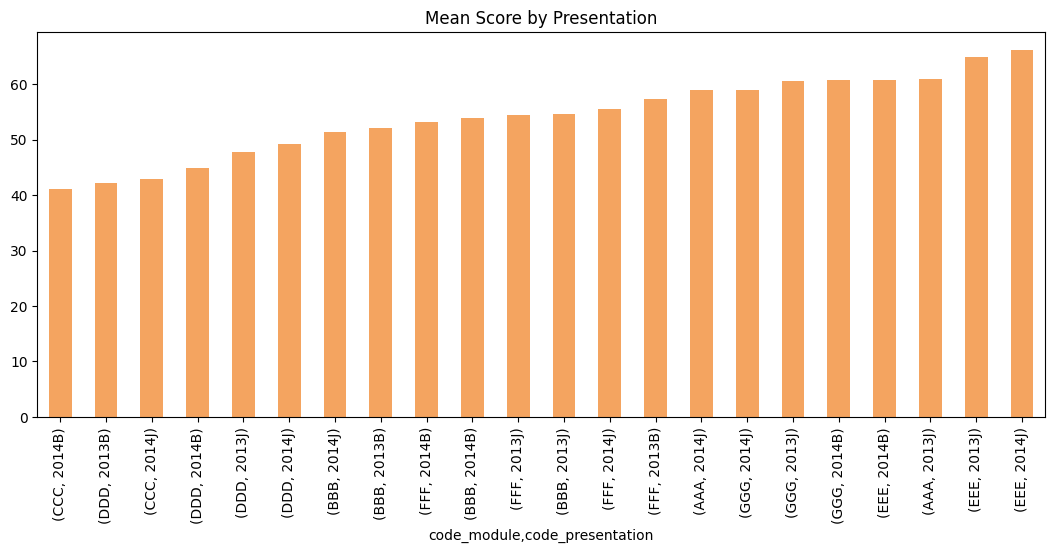

In [ ]:
plt.figure(figsize = (13,5))

plt.title('Mean Score by Presentation')
pres.plot.bar(color=colors[2]);

Если значения колеблются в районе 30%, то может иметь смысл объединить соответствующие столбцы в один с помощью One-Hot Encoding (OHN). Это позволит уменьшить размерность данных и улучшить обработку при анализе.

## Дата регистрации на презентацию

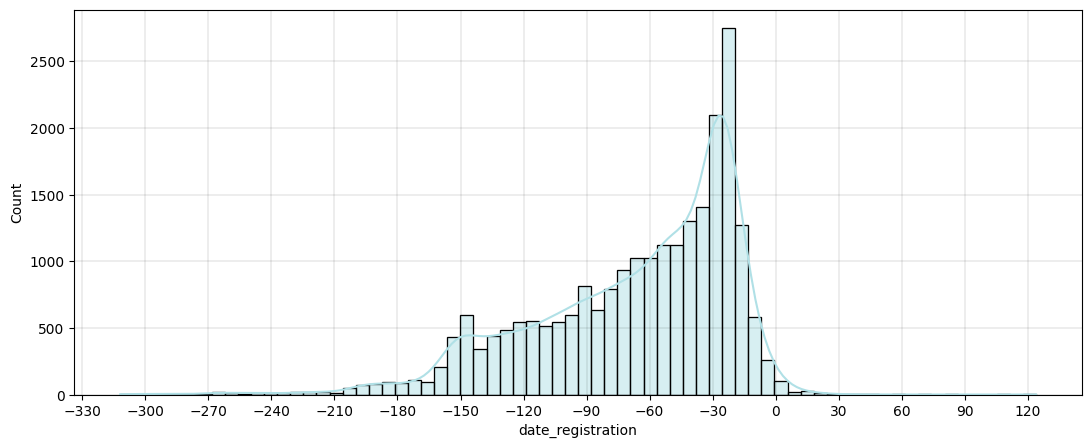

In [ ]:
plt.figure(figsize = (13,5))

ax = sns.histplot(data=df.date_registration, kde=True, bins=70, color=colors[9])
ax.grid(color = 'black', linewidth = .1,);
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))


Большинство студентво записываются на курс за месяц до начала. Пока неизвестно как данный признак влияет на успеваемость.

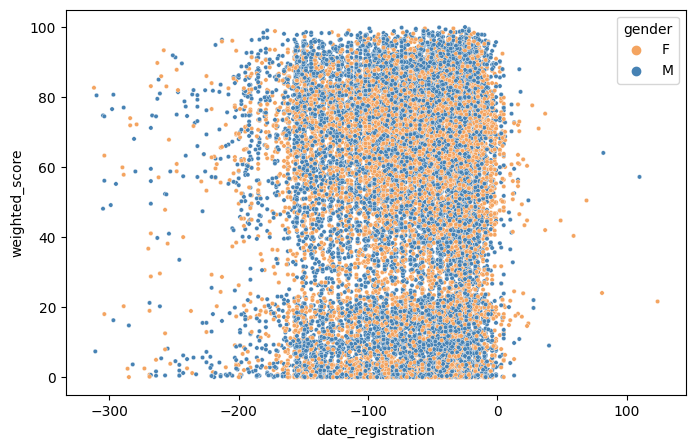

In [ ]:
plt.figure(figsize = (8,5))

ax = sns.scatterplot(x='date_registration', y='weighted_score', data=df, hue='gender', palette=colors[2:4], s=10)

Зависимость не наблюдается ни от пола, ни от успеваемости.

## Длина модуля-презентации

In [ ]:
p_length = df.groupby(['module_presentation_length'])['weighted_score'].mean()

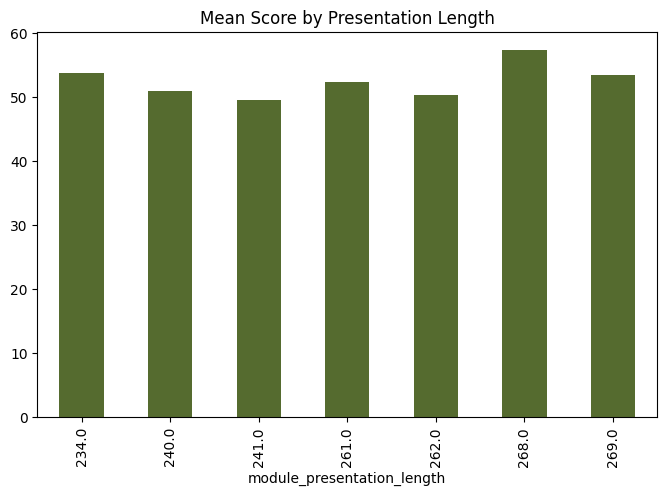

In [ ]:
plt.figure(figsize = (8,5))

plt.title('Mean Score by Presentation Length')
p_length.plot.bar(color=colors[1]);

Оценки распределены хаотично, длина модуля не влияет на успеваемость.

## Пол студента

<Figure size 2000x400 with 0 Axes>

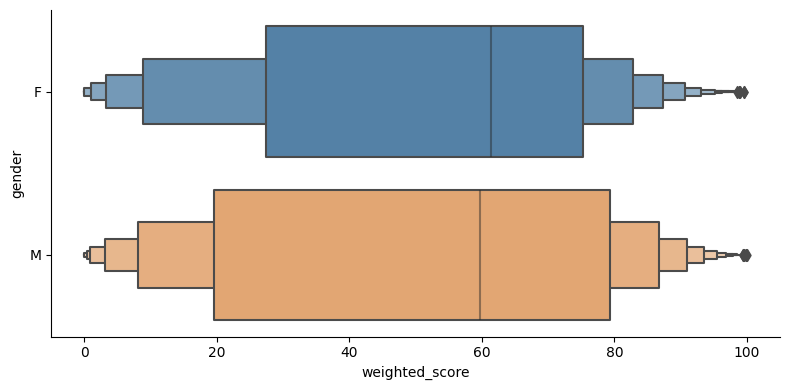

In [ ]:
plt.figure(figsize=(20,4))
sns.catplot(y="gender", x="weighted_score", data=df, height=4, aspect=2, kind='boxen', palette=colors[3:1:-1])

Успеваемость практически не зависит от пола, как медианные значения, так и крайние.

## Географический регион

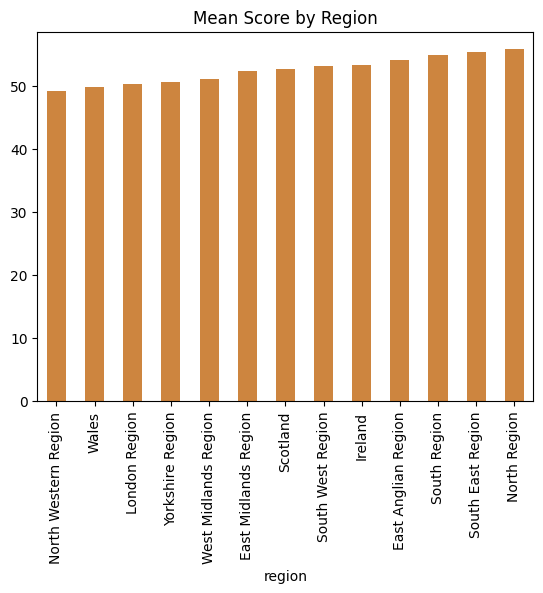

In [ ]:
region = df.groupby(['region'])['weighted_score'].mean().sort_values()

plt.title('Mean Score by Region')
region.plot.bar(color=colors[7]);

Успеваемость мало зависит от географического региона. Средние оценки колеблются в районе 5 баллов.

## Уровень образования

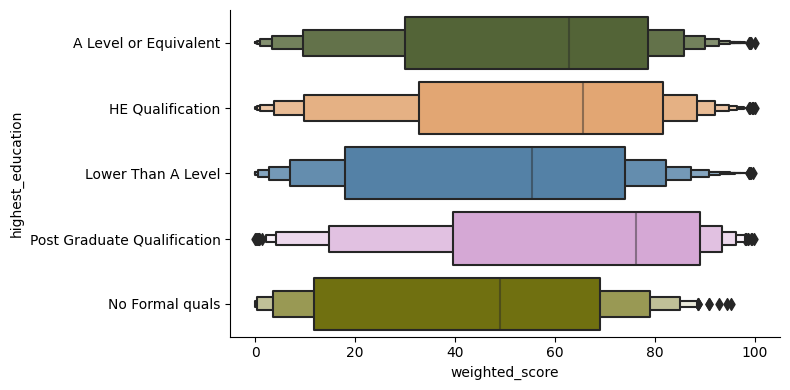

In [ ]:
sns.catplot(data=df, y="highest_education", x="weighted_score", height=4, aspect=2, kind='boxen', palette=colors[1:-1])

Уровень образования влияет на успеваемость, что не удивительно.

## Блогополучность района

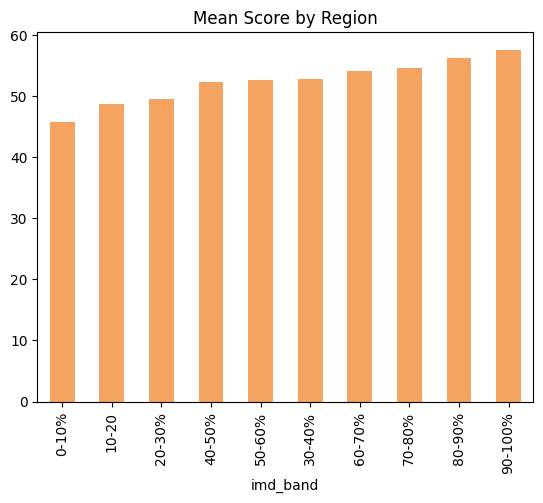

In [ ]:
region = df.groupby(['imd_band'])['weighted_score'].mean().sort_values()

plt.title('Mean Score by Region')
region.plot.bar(color=colors[2]);

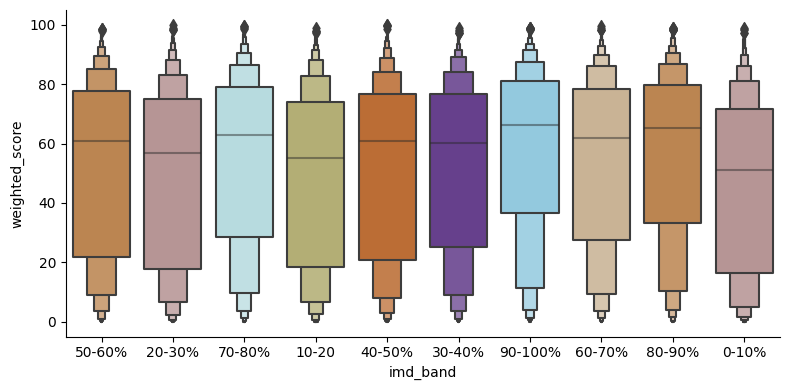

In [ ]:
sns.catplot(data=df, x="imd_band", y="weighted_score", height=4, aspect=2, kind='boxen', palette=colors[7:-1]);

Успеваемость напрямую зависит от блогополучности района.

В богатых районах учатся лучше, чем в бедных. Дисперсия у богатых также меньше.

## Возраст

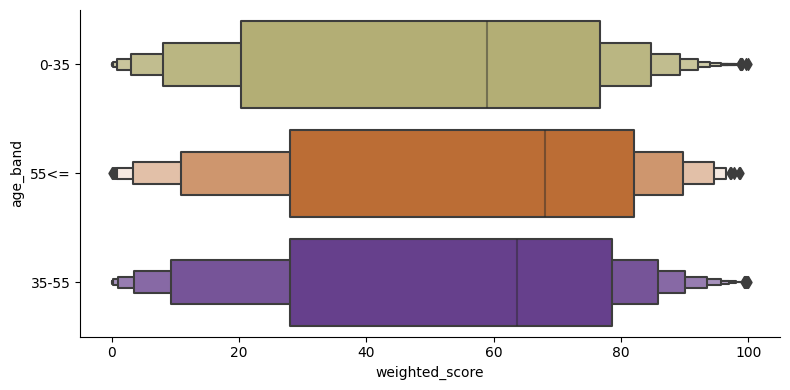

In [ ]:
sns.catplot(data=df, y="age_band", x="weighted_score", height=4, aspect=2, kind='boxen', palette=colors[10:-1]);

Чем старше студент, тем выше успеваемость. Самая большая дисперсия в возрасте 0-35.

## Количество попыток сдачи модуля-презентации

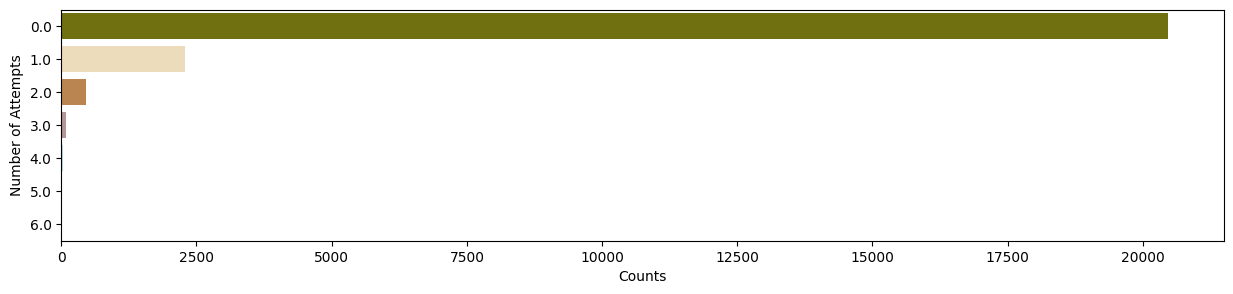

In [ ]:
plt.figure(figsize = (15,3))
attempts = df.num_of_prev_attempts.value_counts().reset_index()
ax = sns.barplot(data=attempts, x='num_of_prev_attempts', y='index', palette=colors[5:15], orient='h');
ax.set_xlabel('Counts')
ax.set_ylabel('Number of Attempts');

Количество студентов сдающих более 1, 2 раз уменьшается в прогрессии

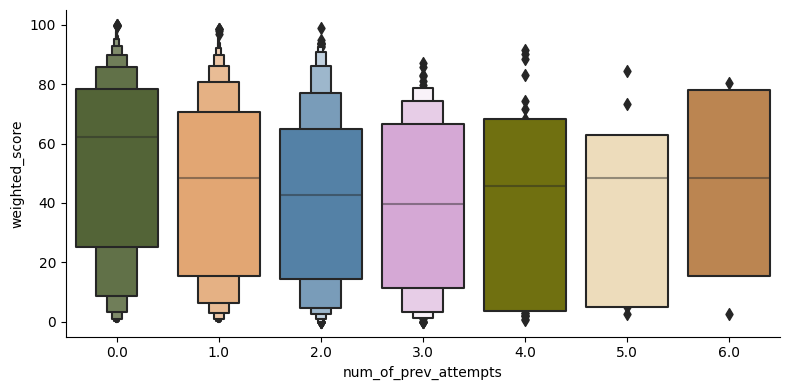

In [ ]:
sns.catplot(data=df, x="num_of_prev_attempts", y="weighted_score", height=4, aspect=2, kind='boxen', palette=colors[1:-1])

Самая высокая успеваемость у тех, кто сдает с 1 раза.

## Кредиты под модулям

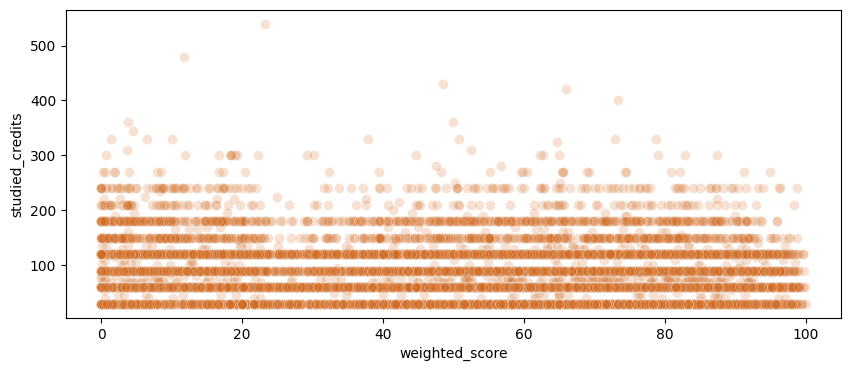

In [ ]:
plt.figure(figsize = (10,4))
sns.scatterplot(df, y = "studied_credits", x = "weighted_score", color=colors[11], s=50, alpha=0.2);

В целом кредиты распределены равномерно по успеваемости. Чем больше кредиты, тем реже они встречаются.

## Инвалидность

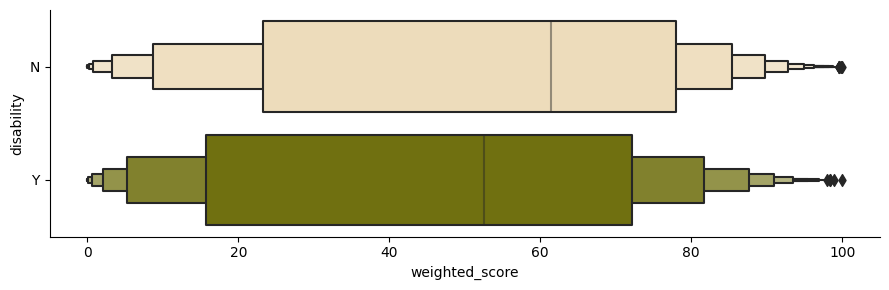

In [ ]:
sns.catplot(data=df, y="disability", x="weighted_score", height=3, aspect=3, kind='boxen', palette=colors[6:0:-1])

Количество кликов увеличивает вероятность более высокой успеваемости

In [ ]:
cm = sns.color_palette("YlOrBr", as_cmap=True)
data_num = Train
data_num.corr(numeric_only=True).style.background_gradient(cmap=cm, vmin = 0, vmax=1)

,date_registration,module_presentation_length,num_of_prev_attempts,studied_credits,mean_date_submitted,res_count,Before_Clicks_1,date
date_registration,1.000000,-0.041839,-0.017882,-0.060719,0.036628,-0.009480,-0.052665,-0.043930
module_presentation_length,-0.041839,1.000000,-0.063917,-0.024526,0.062686,-0.082796,0.031268,0.066974
num_of_prev_attempts,-0.017882,-0.063917,1.000000,0.178706,-0.129807,-0.007743,-0.078024,-0.072514
studied_credits,-0.060719,-0.024526,0.178706,1.000000,-0.151095,0.009425,-0.016096,-0.033945
mean_date_submitted,0.036628,0.062686,-0.129807,-0.151095,1.000000,0.664271,0.354209,0.441421
res_count,-0.009480,-0.082796,-0.007743,0.009425,0.664271,1.000000,0.441230,0.470776
Before_Clicks_1,-0.052665,0.031268,-0.078024,-0.016096,0.354209,0.441230,1.000000,0.971856
date,-0.043930,0.066974,-0.072514,-0.033945,0.441421,0.470776,0.971856,1.000000


Наиболее подсвеченный признак - 'beffore_Clicks_1'. Можно удалить его из выборки.

In [ ]:
num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

df_1=df[num_cols]

corr_df=pd.DataFrame(df_1.corr()["weighted_score"].sort_values(ascending=False)[:15])
corr_df.style.background_gradient(cmap='Blues')


We have 9 numeric columns: date_registration, module_presentation_length, num_of_prev_attempts, studied_credits, mean_date_submitted, res_count, Before_Clicks_1, date, weighted_score
And 9 categorical columns: id_student, code_module, code_presentation, gender, region, highest_education, imd_band, age_band, disability


,weighted_score
weighted_score,1.000000
mean_date_submitted,0.689705
res_count,0.569507
date,0.525092
Before_Clicks_1,0.468303
module_presentation_length,0.057775
date_registration,0.003701
studied_credits,-0.105103
num_of_prev_attempts,-0.107220


# Обучение модели

## Подготовка данных

Еще раз посмотрим на пропуски

In [ ]:
Train.isna().sum()

id_student                       0
code_module                      0
code_presentation                0
date_registration             2714
module_presentation_length    2710
gender                        2710
region                        2710
highest_education             2710
imd_band                      3553
age_band                      2710
num_of_prev_attempts          2710
studied_credits               2710
disability                    2710
mean_date_submitted           5051
res_count                     5051
Before_Clicks_1               2710
date                          2710
dtype: int64

In [ ]:
Train.shape

(26074, 17)

Удалим строки с пустыми значениями в 'date_registration'. Это поможет избавиться от пустых строк по многим признакам. Последующий анализ покажет, что без пропусков оценки выше.

In [ ]:
na_idx1 = Train[Train['date_registration'].isna()].index
Target.drop(index=na_idx1, inplace=True)
Train.drop(index=na_idx1, inplace=True)
Train.shape, Target.shape

((23360, 17), (23360, 1))

Наверное использовать id студента - так себе вариант

Значит - удалим

In [ ]:
na_idx2 = Train[Train['res_count'].isna()].index
Target.drop(index=na_idx2, inplace=True)
Train.drop(index=na_idx2, inplace=True)
Train.shape, Target.shape

((21020, 17), (21020, 1))

In [ ]:
Train.isna().sum()

id_student                      0
code_module                     0
code_presentation               0
date_registration               0
module_presentation_length      0
gender                          0
region                          0
highest_education               0
imd_band                      808
age_band                        0
num_of_prev_attempts            0
studied_credits                 0
disability                      0
mean_date_submitted             0
res_count                       0
Before_Clicks_1                 0
date                            0
dtype: int64

Остались пропуски только по одному признаку - бедность района. Не самый показательгный признак. Пока оставим.

In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21020 entries, 0 to 26073
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  21020 non-null  object 
 1   code_module                 21020 non-null  object 
 2   code_presentation           21020 non-null  object 
 3   date_registration           21020 non-null  float64
 4   module_presentation_length  21020 non-null  float64
 5   gender                      21020 non-null  object 
 6   region                      21020 non-null  object 
 7   highest_education           21020 non-null  object 
 8   imd_band                    20212 non-null  object 
 9   age_band                    21020 non-null  object 
 10  num_of_prev_attempts        21020 non-null  float64
 11  studied_credits             21020 non-null  float64
 12  disability                  21020 non-null  object 
 13  mean_date_submitted         210

In [ ]:
Train.drop(columns = ['id_student'], inplace = True)
Test.drop(columns = ['id_student'], inplace = True)

Дропнем колонку, которая имеют высокую корелляцию.

In [ ]:
cols_to_drop = ['Before_Clicks_1']

In [ ]:
Train.drop(columns=cols_to_drop, axis=1, inplace=True)
Test.drop(columns=cols_to_drop, axis=1, inplace=True)


In [ ]:
display(Train.head(2))
display(Test.head(2))

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count,date
ID,,,,,,,,,,,,,,,
0,DDD,2014B,-36.0,241.0,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1.0,70.0,N,123.285714,7.0,65566.0
1,DDD,2013J,-32.0,261.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,120.0,N,55.333333,3.0,9671.0


,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count,date
ID,,,,,,,,,,,,,,,
26074,DDD,2014J,-92.0,262.0,M,Scotland,Lower Than A Level,50-60%,0-35,2.0,60.0,N,85.777778,9.0,6553.0
26075,CCC,2014B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пригодилось то, что мы все id-шники закинули в тип данных `object`
теперь можем "автоматически" выполнять предварительную обработку по колонкам

In [ ]:

num_cols =Train.select_dtypes(include=np.number).columns
cat_cols = Train.columns[Train.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")


We have 7 numeric columns: date_registration, module_presentation_length, num_of_prev_attempts, studied_credits, mean_date_submitted, res_count, date
And 8 categorical columns: code_module, code_presentation, gender, region, highest_education, imd_band, age_band, disability


In [ ]:
Train.isna().sum()

code_module                     0
code_presentation               0
date_registration               0
module_presentation_length      0
gender                          0
region                          0
highest_education               0
imd_band                      808
age_band                        0
num_of_prev_attempts            0
studied_credits                 0
disability                      0
mean_date_submitted             0
res_count                       0
date                            0
dtype: int64

In [ ]:
Test.isna().sum()

code_module                      0
code_presentation                0
date_registration              658
module_presentation_length     655
gender                         655
region                         655
highest_education              655
imd_band                       866
age_band                       655
num_of_prev_attempts           655
studied_credits                655
disability                     655
mean_date_submitted           1211
res_count                     1211
date                           655
dtype: int64

In [ ]:
def filling_missing_values(data):
  num_cols =data.select_dtypes(include=np.number).columns
  cat_cols = data.columns[data.dtypes == 'object']
  print(print("size_of_num_and_cat_cols" ), len(num_cols),len(cat_cols))
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  #print("cat_cols_missing_percentage")
  #display(missing_value_df.loc[cat_cols].sort_values(ascending=False,by="percent_missing")[:10])

  miss_cat=missing_value_df.loc[cat_cols][percent_missing!=0]
  miss_num=missing_value_df.loc[num_cols][percent_missing!=0]
  print("filling_columns_cat")
  display(miss_cat)
  print("filling_columns_num")
  display(miss_num)
  #strategy_for_categorial_feature
  imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
  data[miss_cat.index]=imputer.fit_transform(data[miss_cat.index])
  #strategy_for_numerical_feature
  imputer=KNNImputer(n_neighbors=5)
  data[miss_num.index]=imputer.fit_transform(data[miss_num.index])
  return data

In [ ]:
filling_missing_values(Train)
filling_missing_values(Test)

size_of_num_and_cat_cols
None 7 8
filling_columns_cat


,column_name,percent_missing
imd_band,imd_band,3.843958


filling_columns_num


,column_name,percent_missing


size_of_num_and_cat_cols
None 7 8
filling_columns_cat


,column_name,percent_missing
gender,gender,10.047553
region,region,10.047553
highest_education,highest_education,10.047553
imd_band,imd_band,13.284246
age_band,age_band,10.047553
disability,disability,10.047553


filling_columns_num


,column_name,percent_missing
date_registration,date_registration,10.093573
module_presentation_length,module_presentation_length,10.047553
num_of_prev_attempts,num_of_prev_attempts,10.047553
studied_credits,studied_credits,10.047553
mean_date_submitted,mean_date_submitted,18.576469
res_count,res_count,18.576469
date,date,10.047553


,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_date_submitted,res_count,date
ID,,,,,,,,,,,,,,,
26074,DDD,2014J,-92.0,262.0,M,Scotland,Lower Than A Level,50-60%,0-35,2.0,60.0,N,85.777778,9.0,6553.0
26075,CCC,2014B,0.0,0.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,0.0,N,0.000000,0.0,0.0
26076,BBB,2013B,0.0,0.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,0.0,N,0.000000,0.0,0.0
26077,CCC,2014J,-34.0,269.0,M,South Region,A Level or Equivalent,20-30%,0-35,0.0,90.0,N,21.000000,1.0,776.0
26078,BBB,2013J,0.0,0.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,0.0,N,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,DDD,2013J,-54.0,261.0,M,South Region,Lower Than A Level,10-20,0-35,0.0,60.0,Y,41.500000,2.0,1687.0
32589,DDD,2013B,-34.0,240.0,F,Yorkshire Region,A Level or Equivalent,30-40%,0-35,1.0,120.0,N,62.666667,3.0,3726.0
32590,AAA,2013J,-22.0,268.0,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,0.0,120.0,N,114.200000,6.0,59064.0


In [ ]:
numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    #("imputer" ,KNNImputer(n_neighbors=5)),
    ('scaler',   MinMaxScaler())
])
categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)),
   # ('imputer', SimpleImputer(strategy='most_frequent', ))
])
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

preprocessors.fit(Train)
Train_ = preprocessors.transform(Train) # преобразуем  тренировочные данные
Test_ = preprocessors.transform(Test) # преобразуем  тестовые данные

In [ ]:
Train_.shape,  Target.shape

((21020, 52), (21020, 1))

In [ ]:
def plot_predict(y_test,predicted):
  A = np.array(y_test).reshape(-1, 1)
  B = predicted.reshape(-1, 1)

  print(type(predicted))
  print(type(y_test))
  plt.rcParams['figure.figsize'] = 16,5
  plt.figure()
  plt.plot(A[-100:], label="Real")
  plt.plot(B[-100:], label="Predicted")
  plt.legend()
  plt.title("score: real vs predicted")
  plt.ylabel("score")
  plt.xticks(())
  rmse = np.sqrt(mean_squared_error(y_test, predicted))

  print('RMSE: ',rmse)

  print('Variance score: %.2f' % r2_score(y_test, predicted))
  plt.show()


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LinearRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)



pipeline = Pipeline(steps=[
    ('model',  ClfSwitcher())
])



In [ ]:
from sklearn.model_selection import cross_validate
def results(X,y,X_val,y_val,estimator):
  best_=estimator
  best_.fit(X_train, y_train)
# предсказываем на тестовых данных
  y_predict=best_.predict(X_val)

  scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

# используем функцию кросс-валидации

  scores = cross_validate(best_, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=3, random_state=42),return_train_score=True)


  print('Результаты Кросс-валидации')
  DF_cv_forest = pd.DataFrame(scores)
  display(DF_cv_forest)


  print('Ошибка на тестовых данных')
  print('MSE: %.4f' % mean_squared_error(y_val,y_predict))
  print('RMSE: %.4f' % mean_squared_error(y_val,y_predict,squared=False))

  print('R2 : %.4f' %  r2_score(y_val,y_predict))
  plot_predict(y_val,y_predict)

In [ ]:
def split(X,y):
  X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.2, random_state=42)

  print('Training Features Shape:', X_train.shape)
  print('Training Labels Shape:', y_train.shape)
  print('Testing Features Shape:', X_val.shape)
  print('Testing Labels Shape:', y_val.shape)
  return X_train,X_val,y_train,y_val


In [ ]:
X_train,X_val,y_train,y_val=split(Train_,Target)

Training Features Shape: (16816, 52)
Training Labels Shape: (16816, 1)
Testing Features Shape: (4204, 52)
Testing Labels Shape: (4204, 1)


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные в пропорции целевой метки

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,y_train)
# let's print the number of total and selected features


SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))
# let's print the number of total and selected features
selected_feats = pd.DataFrame(X_train).columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))


Total features: 52
selected features: 46
features with coefficients shrank to zero: 6


In [ ]:

X_train=pd.DataFrame(X_train).iloc[:,selected_feats]
X_test=pd.DataFrame(Test_).iloc[:,selected_feats]
X_val=pd.DataFrame(X_val).iloc[:,selected_feats]

In [ ]:
import lightgbm as lgb
max_depth = [int(x) for x in np.linspace(4, 20, num =7)]
n_estimators =[int(x) for x in np.linspace(100, 500, num = 10)]
#max_features = ['log2','sqrt']
num_leaves=[int(x) for x in np.linspace(10, 90, num =10)]
from sklearn.ensemble import GradientBoostingRegressor
parameters = [
   {
        'model': (lgb.LGBMRegressor(random_state=0),),
        'model__n_estimators': n_estimators,
        'model__num_leaves':num_leaves,
        'model__max_depth':max_depth,
        "model__learning_rate": [0.01,0.005],

    }
]

# search across 100 different combinations, and use all available cores
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 16816, number of used features: 46
[LightGBM] [Info] Start training from score 52.484144


In [ ]:
rf_random.best_estimator_


Pipeline(steps=[('model',
                 LGBMRegressor(learning_rate=0.01, max_depth=17,
                               n_estimators=411, num_leaves=81,
                               random_state=0))])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 16816, number of used features: 46
[LightGBM] [Info] Start training from score 52.484144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 15134, number of used features: 46
[LightGBM] [Info] Start training from score 52.537107
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

,fit_time,score_time,test_R2,train_R2,test_-MSE,train_-MSE,test_-MAE,train_-MAE,test_Max,train_Max
0,2.411301,0.104994,0.831359,0.860051,-153.138441,-123.858816,-8.865985,-8.138879,-85.791690,-84.835539
1,2.950659,0.250820,0.819289,0.861228,-157.782371,-123.344489,-9.017166,-8.133434,-67.754825,-82.593880
2,6.126932,0.732275,0.806912,0.861971,-172.042820,-122.424532,-9.472368,-8.089455,-76.608786,-83.989686


Ошибка на тестовых данных
MSE: 168.5372
RMSE: 12.9822
R2 : 0.8054
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RMSE:  12.982187238440062
Variance score: 0.81


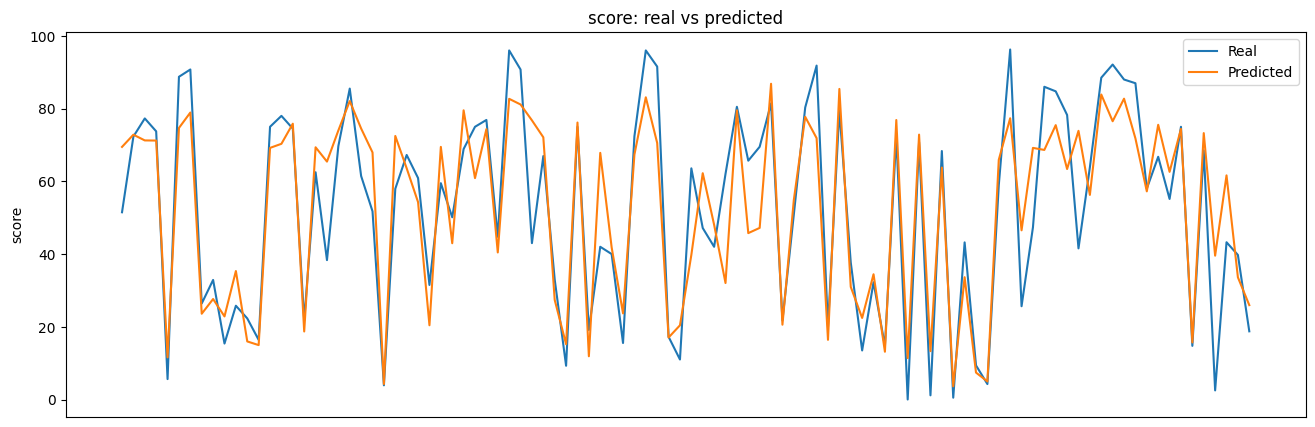

In [ ]:
results( X=X_train,y=y_train,X_val=X_val,y_val=y_val,estimator=rf_random.best_estimator_)

In [ ]:

y_predict=(rf_random.best_estimator_.predict(X_test))

In [ ]:
Submission = pd.read_csv('/content/Submission_reg.csv', index_col = 'ID')
Submission['weighted_score'] = y_predict


In [ ]:

Submission['weighted_score'][:10]

ID
26074    22.302990
26075    10.902159
26076     5.035634
26077     3.722640
26078     5.932243
26079    74.220771
26080    74.328666
26081    14.873977
26082    75.633471
26083    60.079022
Name: weighted_score, dtype: float64

In [ ]:
Submission.to_csv('/content/My_Submission_reg_final_2.csv',index=True) # если хотим чтобы и индексы сохранились -

In [ ]:
#                                ↓ соревнование         ↓ название файла     ↓ комментарий
!kaggle competitions submit -c urfuaieng2022reg2 -f My_Submission_reg_final_2.csv -m " regression test"


100% 154k/154k [00:00<00:00, 585kB/s]
Successfully submitted to UrFU_AI_Eng_2022_Reg_2